In [1]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO #permet de stocker en mémoire
from zipfile import ZipFile
import matplotlib.pyplot as plt

In [2]:
url2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip" #enquete 2019
url2020="https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip" #enquête 2020 en exemple

# Télécharge le fichier ZIP
requete = requests.get(url2019)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2019 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Télécharge le fichier ZIP
requete = requests.get(url2020)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2020 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Statistiques descriptives

Dans cette section, nous examinerons le comportement de la variable ACTEU, qui indique le statut d'activité de l'individu selon les critères du BIT. 

Sont considérées comme étant en emploi toutes les personnes âgées de plus de 15 ans ayant travaillé de manière non bénévole au cours d'une semaine de référence. Les personnes ayant un emploi mais ne l'exerçant pas pour diverses raisons, telles qu'un congé maternité, paternité ou une maladie, font également partie de cette catégorie.

Sont considérées comme étant au chômage toutes les personnes de moins de 75 ans qui n'ont pas d'emploi, qui sont disponibles pour travailler dans les quinze jours à venir, et qui ont entrepris des démarches actives de recherche d'emploi au cours des quatre dernières semaines ou qui commenceront un nouvel emploi dans moins de trois mois.

## Statut d'activité

In [3]:
#Catégories possibles
categories = ["Actif occupé", "Chômeur", "Inactif"]
value = [1,2,3] #on a aussi des NA mais ils ne sont pas pondérés
N=EEC_2019["EXTRIAN"].sum()

#Effectif par catégorie
result_dict = {"ACTEU": categories, 'Effectif': [], 'Proportion':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond = EEC_2019[EEC_2019["ACTEU"]==val]["EXTRIAN"].sum()
    result_dict['Effectif'].append(round(somme_pond,0))
    result_dict['Proportion'].append(round(somme_pond/N,3))
data = pd.DataFrame(result_dict).sort_values(by="ACTEU").reset_index(drop=True)
data

,ACTEU,Effectif,Proportion
0,Actif occupé,27176029.0,0.507
1,Chômeur,2506181.0,0.047
2,Inactif,23963417.0,0.447


In [4]:
#Calcul du taux de chômage selon les critères du BIT
Effectif_chom = data.loc[data["ACTEU"] == "Chômeur"]["Effectif"][1]
Effectif_popactive = data.loc[data["ACTEU"].isin(["Chômeur", "Actif occupé"])]["Effectif"].sum()

print(f"Le taux de chômage en France selon le BIT en 2019 est de {round(100*Effectif_chom/Effectif_popactive,1)}%")

Le taux de chômage en France selon le BIT en 2019 est de 8.4%


## Durée du chômage

In [5]:
#Histogramme de la durée du chômage en pondérant par EXTRIAN (variable de pondération)
plt.hist([EEC_chom_2019["ANCCHOM"],EEC_chom_2020["ANCCHOM"]],bins=[i - 0.5 for i in range(1, 10)], weights = [EEC_chom_2019["EXTRIAN"],EEC_chom_2020["EXTRIAN"]], align='mid',width=0.4, density=True,label=["2019","2020"])
plt.title('Histogramme de la durée du chômage')
plt.xticks(range(1,10), ["< 1 mo","1< <3mo","3< <6mo","6< <12 mo","12< <18 mo","18 mo< <2 y","2< <3 y",">3 y",""], rotation=45, ha="right")
plt.xlabel('Durée du chômage')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

NameError: name 'EEC_chom_2019' is not defined

On a une répartition qui s'apparente à une loi normale centré sur 6 mois. En effet, l'augmentation que l'on observe pour "entre 2 et 3 ans" et "3 ans et plus" est due au fait que ses entrées correspondent à des intervalles plus longs. 

## CSP

On s'intéresse maintenant au statut d'activité et à la catégorie socioprofessionnelle, qui est indiquée uniquement pour la population active. 

In [33]:
#Catégories possibles
categories = ["Non-renseigné", "Agriculteurs", "Artisans, commerçants, chefs d'entreprise", "Cadres et professions intellectuelles supérieures", "Professions intermédiaires", "Employés", "Ouvriers", "Inactifs ayant déjà eu une activité pro", "Chômeurs et inactifs n'ayant jamais travaillé", "NA"]
value = EEC_2019["CSTOTR"].unique()

#tableau avec CSTOR/Effectif en emploi/Effectif chômeur tout cela pondéré par EXTRIAN
result_dict = {"CSTOTR": value, 'Effectif_emploi': [], 'Effectif_chom':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["CSTOTR"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["CSTOTR"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
data = pd.DataFrame(result_dict).sort_values(by="CSTOTR").reset_index(drop=True)
data

,CSTOTR,Effectif_emploi,Effectif_chom
0,0.0,120715.0,12660.0
1,1.0,403572.0,4811.0
2,2.0,1825004.0,75003.0
3,3.0,5240635.0,191348.0
4,4.0,6957339.0,345401.0
5,5.0,7291505.0,737501.0
6,6.0,5337259.0,752857.0
7,7.0,0.0,0.0
8,8.0,0.0,386600.0
9,NaN,0.0,0.0


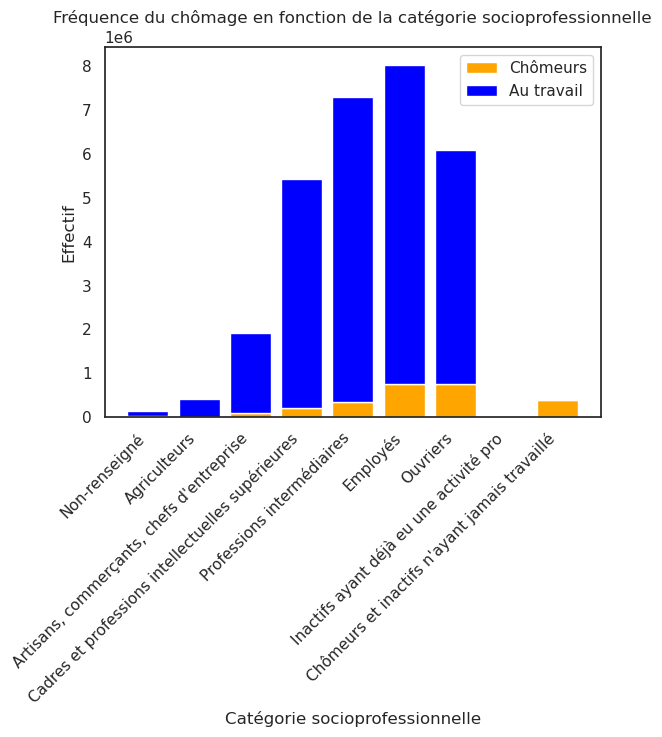

In [34]:
plt.bar(data["CSTOTR"],data["Effectif_chom"], color='orange', label='Chômeurs')
plt.bar(data["CSTOTR"],data["Effectif_emploi"], color='blue', label='Au travail', bottom=data["Effectif_chom"])
plt.title('Fréquence du chômage en fonction de la catégorie socioprofessionnelle')
plt.xlabel('Catégorie socioprofessionnelle')
plt.ylabel('Effectif')
plt.xticks(data["CSTOTR"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

## Age

In [ ]:
#chômage par âge
#Catégories possibles
categories = ["15-29","30-39","40-49","50-59","60+"]

#tableau avec AGE/Effectif en emploi/Effectif chômeur tout cela pondéré par EXTRIAN
result_dict = {"AGE5": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in [15,30,40,50, 60] :
    somme_pond_E = EEC_2019[(EEC_2019["AGE5"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["AGE5"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["AGE5"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),2))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).reset_index(drop=True)
data

In [ ]:
plt.bar(data["AGE5"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["AGE5"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["AGE5"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction de l'âge")
plt.xlabel('Age')
plt.ylabel('Effectif')
plt.xticks(data["AGE5"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

On remarque, tout d'abord, que ce sont les moins de 29 et les plus de 60 ans qui sont les plus inactifs, étant soit en études ou à la retraite.
Néanmoins, alors que le chômage est important pour les jeunes pour de multiples raisons, on remarque un faible chômage pour les plus de 50 ans (plus d'expérience, stabilité de l'emploi acquise avec le temps, possibilité de partir à la retraite...).
La tranche d'âge allant de 30 à 60 recensant principalement des actifs (entre 5 et 7% de chômage et environ 15% d'inactifs).

## Sexe

In [ ]:
#chômage et inactivité par sexe
#Catégories possibles
categories = ["Homme","Femme"]
value = [1,2]

#tableau avec SEXE/Effectif en emploi/Effectif chômeur et pour inactifs tout cela pondéré par EXTRIAN
result_dict = {"SEXE": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["SEXE"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["SEXE"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["SEXE"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),2))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).reset_index(drop=True)
data

In [ ]:
plt.bar(data["SEXE"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["SEXE"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["SEXE"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction du sexe")
plt.xlabel('SEXE')
plt.ylabel('Effectif')
plt.xticks(data["SEXE"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

On remarque tout d'abord qu'il y a proportionnellement plus de femmes inactives, cela s'explique principalement par l'écart d'espérance de vie entre les femmes et les hommes.
Néanmoins, hommes comme femmes ont l'air d'avoir le même taux de sondage (à vérifier test).

## Catégorie de commune

In [ ]:
#chômage et inactivité par taille de la commune
#Catégories possibles
categories = ["Grandes aires urbaines","Autres aires","Autres communes multipolarisées","Communes isolées hors influence des pôles"]
value = EEC_2019["CATAU2010R"].unique()

#tableau avec CAUTAU2010R/Effectif en emploi/Effectif chômeur et pour inactifs tout cela pondéré par EXTRIAN
result_dict = {"CATAU2010R": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["CATAU2010R"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["CATAU2010R"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["CATAU2010R"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),2))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).reset_index(drop=True)
data

In [ ]:
plt.bar(data["CATAU2010R"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["CATAU2010R"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["CATAU2010R"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction du sexe")
plt.xlabel('Catégorie de commune du logement de résidence')
plt.ylabel('Effectif')
plt.xticks(data["CATAU2010R"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

# Analyse en composantes principales

## Normalisation

On va effectuer une analyse en composantes principales sur la base EEC 2019 en essayant de se concentrer sur des variables socio-démographiques disponibles pouvant être correlées (voire expliquées) le statut d'activité.
On s'intéresse au sexe, au niveau d'études, à la catégorie socioprofessionnelle, à la nationalité, au nombre d'heures travaillées voulues, à l'ancienneté du chômage, à l'âge, à la catégorie de la commune et à des variables familialles (couple ? enfants ?), à l'implication dans la recherche d'emploi.

Pour commencer, on doit transformer les variables catégorielles en indicatrices et normaliser entre 0 et 1 les variables numériques.

In [7]:
#Création d'une base PCA
EEC_PCA=EEC_2019
EEC_PCA=pd.DataFrame(EEC_PCA[["EXTRIAN","ACTEU","SEXE","DIP11","CSTOTR","NFRRED","NBTOTE","HPLUSA","HHCE","CONTACT",
"ANCCHOM","AGE5","AIDFAM","CATAU2010R","COURED","ENFRED"]]).reset_index(drop=True)

In [8]:
#ACTEU, création d'une indicatrice chômage et d'une indicatrice inactif
EEC_PCA["CHOM"]=0
EEC_PCA.loc[EEC_PCA["ACTEU"]==2, "CHOM"]=1

EEC_PCA["INAC"]=0
EEC_PCA.loc[EEC_PCA["ACTEU"]==3, "INAC"]=1

In [9]:
#DIP11 que l'on va séparer en indicatrices pour enseignement sup, secondaire et en dessous
EEC_PCA["infcollege"]=0 #infcollege = aucun diplome, certif d'études, brevet
EEC_PCA.loc[EEC_PCA["DIP11"].isin([71,70,60]), "infcollege"]=1

EEC_PCA["secondaireplus"]=0 #secondaire plus = secondaire + BTS et DUT...
EEC_PCA.loc[EEC_PCA["DIP11"].isin([50,42,41,33,31]), "secondaireplus"]=1

EEC_PCA["sup"]=0 #le reste
EEC_PCA.loc[EEC_PCA["DIP11"].isin([30,11,10]), "sup"]=1

In [10]:
#SEXE (0 = H, 1 = F)
EEC_PCA.loc[EEC_PCA["SEXE"]==1, "SEXE_bin"]=0
EEC_PCA.loc[EEC_PCA["SEXE"]==2, "SEXE_bin"]=1

In [11]:
#CSTOTR : en se basant sur le graphique ci-dessus, je crée une catégorie employé avec les professions intermédiaires, les employés et les ouvriers
#et je crée une catégorie employeur avec les cadres sups, artisans, chef d'entreprises
EEC_PCA["employe"]=0 
EEC_PCA.loc[EEC_PCA["CSTOTR"].isin([4,5,6]), "employe"]=1

EEC_PCA["employeur"]=0 
EEC_PCA.loc[EEC_PCA["CSTOTR"].isin([2,3]), "employeur"]=1
#on a 3/4 de l'échantillon employe et 1/4 employeur

In [12]:
#NFRRED : variable indicatrice : "l'individu est-il de nationalité française ?"
EEC_PCA["NAT"]=0
EEC_PCA.loc[EEC_PCA["NFRRED"].isin([1,2]), "NAT"]=1
#1/20 sans nationalité FR

In [13]:
#AGE5 : transformer en deux indicatrices jeunes actifs (15 à 29 ans) ou actifs âgés (plus de 50 ans)
EEC_PCA["JEUNE"]=0 
EEC_PCA.loc[EEC_PCA["AGE5"]==15, "JEUNE"]=1

EEC_PCA["ANCIEN"]=0 
EEC_PCA.loc[EEC_PCA["AGE5"].isin([50,60]), "ANCIEN"]=1
#1/5 de jeunes et 1/3 d'anciens

In [14]:
#CONTACT : contact avec pôle emploi depuis dernière enquête (3 mois), 1 si oui
EEC_PCA["P_E"]=0
EEC_PCA.loc[EEC_PCA["CONTACT"]==1, "P_E"]=1
#moins d'1/20

In [15]:
#création de rural. 1 si l'individu n'habite pas dans un grande aire urbaine : 1/5 échantillon
EEC_PCA["rural"]=1
EEC_PCA.loc[EEC_PCA["CATAU2010R"]==1, "rural"]=0

In [16]:
#COURED : 1 si l'individu est en couple
EEC_PCA["COUPLE"]=0
EEC_PCA.loc[EEC_PCA["COURED"]==1, "COUPLE"]=1
#2/3 en couple

In [17]:
#ENFRED : 1 si l'individu a un enfant
EEC_PCA["ENF"]=0
EEC_PCA.loc[EEC_PCA["ENFRED"]==1, "ENF"]=1
#la moitié a un enfant

In [20]:
from sklearn.preprocessing import MinMaxScaler #pour normaliser entre 0 et 1

In [21]:
#NBTOTE : Nbre d'heures travaillées par semaine en moyenne par l'individu
col = EEC_PCA['NBTOTE']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['NBTOTE'] = colonne_normalisee
EEC_PCA["NBTOTE"].describe()
#très peu d'entrées dans cette variable (à remédier)

count    9462.000000
mean        0.629828
std         0.230385
min         0.000000
25%         0.495798
50%         0.647059
75%         0.781513
max         1.000000
Name: NBTOTE, dtype: float64

In [22]:
#HPLUSA (pour les personnes à qui leur charge horraire convient, on remplace NA par leur charge horraire actuelle)
EEC_PCA["HHCE"]=EEC_PCA["HHCE"].fillna(0)
EEC_PCA.loc[EEC_PCA['HPLUSA'].isna(), "HPLUSA"]=EEC_PCA[EEC_PCA['HPLUSA'].isna()]["HHCE"]

In [23]:
col = EEC_PCA['HPLUSA']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['HPLUSA'] = colonne_normalisee
EEC_PCA["HPLUSA"].describe()

count    416298.000000
mean          0.174642
std           0.201204
min           0.000000
25%           0.000000
50%           0.000000
75%           0.361809
max           1.000000
Name: HPLUSA, dtype: float64

In [24]:
#ANCCHOM : ancienneté du chômage, recodage en mois pour normaliser
EEC_PCA["ANCCH"]=0.0#en emploi
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==1, "ANCCH"]=1.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==2, "ANCCH"]=2.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==3, "ANCCH"]=4.5
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==4, "ANCCH"]=9.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==5, "ANCCH"]=15.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==6, "ANCCH"]=21.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==7, "ANCCH"]=30.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==8, "ANCCH"]=40.0
EEC_PCA["ANCCH"].describe()

count    416298.000000
mean          0.680171
std           4.274341
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          40.000000
Name: ANCCH, dtype: float64

In [25]:
col = EEC_PCA['ANCCH']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['ANCCH'] = colonne_normalisee
EEC_PCA["ANCCH"].describe()

count    416298.000000
mean          0.017004
std           0.106859
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ANCCH, dtype: float64

## Matrice de covariances

Avec ces variables normalisées, on réalise maintenant la matrice de covariances et sa heatmap. On veille à respecter la pondération de chaque individu.

In [26]:
EEC_PCA1=EEC_PCA[['HPLUSA', 'CHOM','INAC', 'infcollege', 'P_E',"ANCCH",
       'secondaireplus', 'sup', 'SEXE_bin', 'employe', 'employeur', 'NAT',
       'JEUNE', 'ANCIEN', 'rural', 'COUPLE', 'ENF']] #on omet NBTOTE pas assez d'ind.
noms_var=EEC_PCA1.columns
EEC_PCAW=EEC_PCA["EXTRIAN"].to_numpy()
EEC_PCA1.head()

,HPLUSA,CHOM,INAC,infcollege,P_E,ANCCH,secondaireplus,sup,SEXE_bin,employe,employeur,NAT,JEUNE,ANCIEN,rural,COUPLE,ENF
0,0.00000,0,1,1,0,0.0,0,0,1.0,0,0,1,0,1,0,0,0
1,0.01005,0,0,0,0,0.0,1,0,0.0,1,0,1,0,1,0,1,0
2,0.00000,0,1,1,0,0.0,0,0,1.0,0,0,1,0,1,0,1,0
3,0.01005,0,0,0,0,0.0,1,0,0.0,1,0,1,0,1,0,1,0
4,0.00000,0,1,1,0,0.0,0,0,1.0,0,0,1,0,1,0,1,0


In [27]:
EEC_COV_NP=np.cov(EEC_PCA1.to_numpy(), rowvar=False, aweights=EEC_PCAW)
EEC_COV=pd.DataFrame(EEC_COV_NP) #matrice de covariance pondérée
EEC_COV.columns = noms_var #on affiche le nom des variables correspondantes en x et y
EEC_COV.set_index(EEC_COV.columns, inplace=True)
EEC_COV

,HPLUSA,CHOM,INAC,infcollege,P_E,ANCCH,secondaireplus,sup,SEXE_bin,employe,employeur,NAT,JEUNE,ANCIEN,rural,COUPLE,ENF
HPLUSA,0.041428,-0.008964,-0.085715,-0.031662,-0.002925,-0.003011,0.013564,0.017932,-0.013064,0.054870,0.029508,0.001684,-0.006544,-0.032863,-0.002920,0.018821,0.034300
CHOM,-0.008964,0.044535,-0.020869,-0.000803,0.012456,0.014957,0.002101,-0.001355,-0.001936,0.015565,-0.001420,-0.002415,0.007148,-0.011807,-0.000966,-0.007126,0.001146
INAC,-0.085715,-0.020869,0.247160,0.079704,-0.005615,-0.007009,-0.038920,-0.040319,0.020878,-0.178377,-0.061053,-0.000551,0.005604,0.096678,0.008756,-0.037614,-0.087091
infcollege,-0.031662,-0.000803,0.079704,0.208357,-0.000811,0.000647,-0.150956,-0.056733,0.008364,-0.046182,-0.032312,-0.013112,0.003213,0.041956,0.009851,-0.028624,-0.032177
P_E,-0.002925,0.012456,-0.005615,-0.000811,0.026948,0.004723,0.002093,-0.001358,-0.000013,0.005873,-0.001267,-0.001316,0.001312,-0.005720,0.000012,-0.002581,0.002626
ANCCH,-0.003011,0.014957,-0.007009,0.000647,0.004723,0.009866,0.000281,-0.000941,-0.000745,0.005101,-0.000570,-0.000973,0.000714,-0.002454,-0.000276,-0.002567,0.000701
secondaireplus,0.013564,0.002101,-0.038920,-0.150956,0.002093,0.000281,0.249899,-0.097790,-0.010525,0.060223,-0.022868,0.013658,-0.001734,-0.016560,0.005361,0.014673,0.018450
sup,0.017932,-0.001355,-0.040319,-0.056733,-0.001358,-0.000941,-0.097790,0.154956,0.002329,-0.013622,0.055321,-0.000477,-0.002097,-0.024736,-0.014976,0.014304,0.013745
SEXE_bin,-0.013064,-0.001936,0.020878,0.008364,-0.000013,-0.000745,-0.010525,0.002329,0.249493,-0.000091,-0.018542,-0.000008,-0.004576,0.007778,-0.001049,-0.013818,0.012492
employe,0.054870,0.015565,-0.178377,-0.046182,0.005873,0.005101,0.060223,-0.013622,-0.000091,0.239865,-0.054577,-0.000556,0.004219,-0.076915,-0.002042,0.019490,0.061240


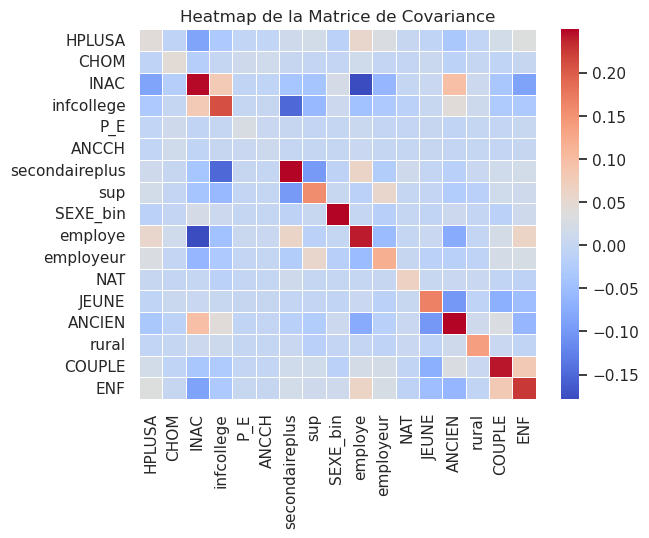

In [28]:
import seaborn as sns

# Utiliser seaborn pour créer la heatmap
sns.set(style="white")
sns.heatmap(EEC_COV, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Afficher la heatmap
plt.title('Heatmap de la Matrice de Covariance')
plt.show()

## PCA

On réalise maintenant l'analyse en composantes principales.

In [29]:
from sklearn.decomposition import PCA

# Appliquer la PCA
pca = PCA()
composantes_principales = pca.fit(EEC_COV).components_

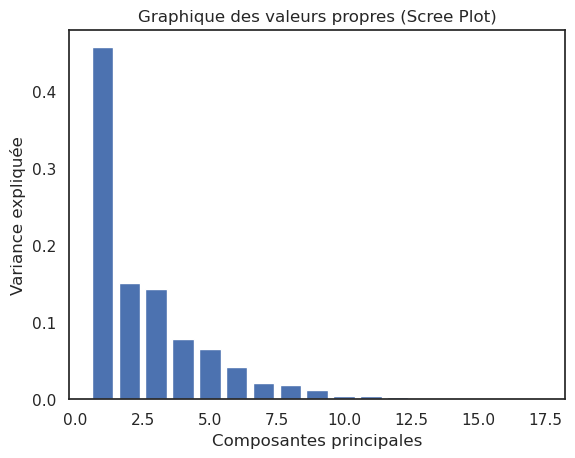

In [31]:
# Graphique des valeurs propres
valeurs_propres = pca.explained_variance_ratio_
plt.bar(range(1, len(valeurs_propres) + 1), valeurs_propres)
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Graphique des valeurs propres (Scree Plot)')
plt.show()

On remarque que la première composante est très "explicative" de la répartition de nos individus selon ces variables.

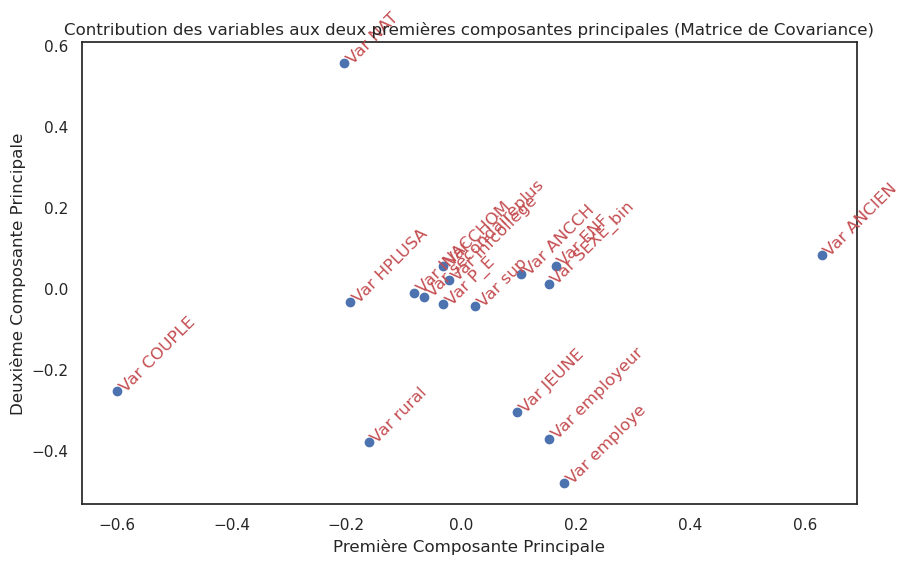

In [32]:
# Sélectionner les deux premiers vecteurs propres
first_pc = composantes_principales[:, 0]
second_pc = composantes_principales[:, 1]
variable_names = EEC_COV.columns.tolist()

# Tracer le graphique de dispersion des deux premières composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(first_pc, second_pc)

# Annoter chaque point avec le nom de la variable
for i, variable in enumerate(variable_names):
    plt.annotate(f'Var {variable}', (first_pc[i], second_pc[i]), color='r', rotation=45)

# Ajouter des labels et un titre au graphique
plt.title('Contribution des variables aux deux premières composantes principales (Matrice de Covariance)')
plt.xlabel('Première Composante Principale')
plt.ylabel('Deuxième Composante Principale')

# Afficher le graphique
plt.show()

# Modélisation

## Partie I: Preparation des données (preprocessing)

In [ ]:
# On choisit un set de features qui ne comprend que données sociodémographiques, géographiques associées à l'individu
# et au ménage étudié + qui sont disponibles sur les deux années étudiées

# label -> ACTEU

# features à inclure dans le modèle -> AGE3 ;  AGE5 ; ANNEE ;TRIM ;  CATAU2010R ; COURED ;
# DIP11; ENFRED ; METRODOM ; NFRRED ; SEXE ; TYPMEN7 

# Il faut supprimer CSTOT /  CSTOTPRM / CSTOTR puisque ce sont des variables après filtre sur actifs/ inactifs

# Rajouter CSA + CSP ? Catégorie d'emploi mais dispo pour tout le monde

# Meme si les variables sont colinéaires (AGE3, AGE5), on peut les garder et faire en sorte que le predicteur
# choisisse la plus pertinente

# Je pense que le problème principal vient du fait qu'on a en fait trop peu de variable, et donc rien qui ne puisse être vraiment pertinent en fait
#c'est pour cela que les algorithmes ne trouvent rien je pense.

list_var_selected = ["ACTEU","ANNEE" ,"TRIM", "AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSA" ,"CSP" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"]

EEC_2019 = EEC_2019[list_var_selected]
EEC_2020 = EEC_2020[list_var_selected]

list_var = list(EEC_2019.columns.values)
print(list_var)

### Une série de recodages pour les PCS

In [ ]:
#Création d'une variable de PCS avec la PCS des actifs occupés et l'ancienne des inactifs et chômeurs.
non_nan_csp = EEC_2019['CSP'].notna()
non_nan_csa = EEC_2019['CSA'].notna()

# Vérifiez si les variables sont renseignées pour les mêmes individus
positions_differentes = (non_nan_csp != non_nan_csa).any()

# Affichez le résultat
if positions_differentes:
    print("Les variables ne sont pas renseignées pour les mêmes individus")
else:
    print("Les variables sont renseignées pour les mêmes individus")

In [ ]:
#On peut donc sommer les deux colonnes
EEC_2019['PCS'] = EEC_2019['CSA'].add(EEC_2019['CSP'], fill_value=0)

pcs_manquante = EEC_2019['PCS'].isna().sum()

print(pcs_manquante)
#1260 valeurs manquantes, donc assez peu

In [ ]:
#Idem pour EEC_2020
#Création d'une variable de PCS avec la PCS des actifs occupés et l'ancienne des inactifs et chômeurs.
non_nan_csp = EEC_2020['CSP'].notna()
non_nan_csa = EEC_2020['CSA'].notna()

# Vérifiez si les variables sont renseignées pour les mêmes individus
positions_differentes = (non_nan_csp != non_nan_csa).any()

# Affichez le résultat
if positions_differentes:
    print("Les variables ne sont pas renseignées pour les mêmes individus")
else:
    print("Les variables sont renseignées pour les mêmes individus")

#On peut donc sommer les deux colonnes
EEC_2020['PCS'] = EEC_2020['CSA'].add(EEC_2020['CSP'], fill_value=0)

pcs_manquante = EEC_2020['PCS'].isna().sum()

print(pcs_manquante)
#864 valeurs manquantes, donc très peu

In [ ]:
EEC_2019 = EEC_2019.drop(['CSA', 'CSP'], axis=1)
EEC_2020 = EEC_2020.drop(['CSA', 'CSP'], axis=1)

### Gestion des NAN

In [ ]:
#Comptons le nombre de NaN dans nos df
nombre_lignes_nan_2019 = EEC_2019.isnull().any(axis=1).sum()
nombre_lignes_nan_2020 = EEC_2020.isnull().any(axis=1).sum()
print(nombre_lignes_nan_2019)
print(nombre_lignes_nan_2020)

In [ ]:
#Isolons nos observations avec des NAN
EEC_2019_with_nulls = EEC_2019[EEC_2019.isna().any(axis=1)]
EEC_2020_with_nulls = EEC_2020[EEC_2020.isna().any(axis=1)]

In [ ]:
print(EEC_2019_with_nulls.shape)
print(EEC_2020_with_nulls.shape)

In [ ]:
EEC_2019_with_nulls['total_nan'] = EEC_2019_with_nulls.isna().sum(axis=1)

In [ ]:
print(EEC_2019_with_nulls['total_nan'].mean())
#En moyenne, 1,79 valeurs manquantes, sur 14 variables

In [ ]:
nan_count_variable_2019 = EEC_2019_with_nulls.isna().sum()
print(nan_count_variable_2019)
nan_percentage_variable_2019 = (EEC_2019_with_nulls.isna().sum() / len(EEC_2019_with_nulls)) * 100
print(nan_percentage_variable_2019)
#A chaque fois il nous manque donc le diplôme, et dans environ un tiers des cas la PCS recodée et la variable d'intérêt, un cinquième des nationalités

In [ ]:
EEC_2020_with_nulls['total_nan'] = EEC_2020_with_nulls.isna().sum(axis=1)
print(EEC_2020_with_nulls['total_nan'].mean())
#En moyenne, 1,67 valeurs manquantes, sur 14 variables
nan_count_variable_2020 = EEC_2020_with_nulls.isna().sum()
print(nan_count_variable_2020)
nan_percentage_variable_2020 = (EEC_2020_with_nulls.isna().sum() / len(EEC_2020_with_nulls)) * 100
print(nan_percentage_variable_2020)
#On retrouve des choses très semblables sur 2020, avec encore une fois surtout le diplôme qui manque

In [ ]:
#Commençons par supprimer les observations pour lesquelles notre variable d'intérêt n'est pas renseignée --> inutilisables
EEC_2019_with_nulls_non_ACTEU = EEC_2019_with_nulls.dropna(subset=['ACTEU'])
EEC_2019_with_nulls_non_ACTEU['total_nan'] = EEC_2019_with_nulls_non_ACTEU.isna().sum(axis=1)
print(EEC_2019_with_nulls_non_ACTEU['total_nan'].mean())
#En moyenne, 1,01 valeurs manquantes, sur 13 variables
nan_count_variable_2019_non_ACTEU = EEC_2019_with_nulls_non_ACTEU.isna().sum()
print(nan_count_variable_2019_non_ACTEU)
nan_percentage_variable_2019_non_ACTEU = (EEC_2019_with_nulls_non_ACTEU.isna().sum() / len(EEC_2019_with_nulls_non_ACTEU)) * 100
print(nan_percentage_variable_2019_non_ACTEU)
#A part une poignée de nationalités, il ne manque plus que le diplôme, pour tout le monde.

In [ ]:
#Commençons par supprimer les observations pour lesquelles notre variable d'intérêt n'est pas renseignée --> inutilisables
EEC_2020_with_nulls_non_ACTEU = EEC_2020_with_nulls.dropna(subset=['ACTEU'])
EEC_2020_with_nulls_non_ACTEU['total_nan'] = EEC_2020_with_nulls_non_ACTEU.isna().sum(axis=1)
print(EEC_2020_with_nulls_non_ACTEU['total_nan'].mean())
#En moyenne, 1,01 valeurs manquantes, sur 13 variables
nan_count_variable_2020_non_ACTEU = EEC_2020_with_nulls_non_ACTEU.isna().sum()
print(nan_count_variable_2020_non_ACTEU)
nan_percentage_variable_2020_non_ACTEU = (EEC_2020_with_nulls_non_ACTEU.isna().sum() / len(EEC_2020_with_nulls_non_ACTEU)) * 100
print(nan_percentage_variable_2020_non_ACTEU)
#A part une poignée de nationalités, il ne manque plus que le diplôme, pour tout le monde.

In [ ]:
# Il y a très peu de valeurs manquantes dans les variables, 4205 variables concernées en 2019, 3379 en 2020.
#Si on supprime d'office les observations pour lesquelles manquent la variable d'intérêt, on tombe à 2945 et 2515, et c'est systématiquement le diplôme qui manque
#On choisit donc de les supprimer de la base pour le moment
print(EEC_2019.shape)
print(EEC_2020.shape)
EEC_2019 = EEC_2019.dropna() 
EEC_2020 = EEC_2020.dropna() 
print(EEC_2019.shape)
print(EEC_2020.shape)

### Suite et fin du préprocessing

In [ ]:
# Converti l'ensemble des variables catégorielles en dummies
# Oui oui faut le faire, par contre pour les variables qui sont DEJA des dummies, c'est pas la peine, faut juste les recoder en 0 et 1
EEC_2019 = pd.get_dummies(EEC_2019, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"PCS", "DIP11", "NFRRED" , "TYPMEN7"])
EEC_2020 = pd.get_dummies(EEC_2020, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"PCS" , "DIP11", "NFRRED" , "TYPMEN7"])

#RECODAGE variables binaires (dummies)

EEC_2019['EMPLOI'] = EEC_2019['ACTEU'].apply(lambda x: x == 1)
EEC_2020['EMPLOI'] = EEC_2020['ACTEU'].apply(lambda x: x == 1)

EEC_2019['ACTIF'] = EEC_2019['ACTEU'].apply(lambda x: (x == 1) or (x == 2))
EEC_2020['ACTIF'] = EEC_2020['ACTEU'].apply(lambda x: (x == 1) or (x == 2))

EEC_2019['FEMME'] = EEC_2019['SEXE'].apply(lambda x: x == 2)
EEC_2020['FEMME'] = EEC_2020['SEXE'].apply(lambda x: x == 2)

EEC_2019['COUPLE'] = EEC_2019['COURED'].apply(lambda x: x == 2)
EEC_2020['COUPLE'] = EEC_2020['COURED'].apply(lambda x: x == 2)

EEC_2019['ENFANT'] = EEC_2019['ENFRED'].apply(lambda x: x == 2)
EEC_2020['ENFANT'] = EEC_2020['ENFRED'].apply(lambda x: x == 2)


EEC_2019['DOM'] = EEC_2019['METRODOM'].apply(lambda x: x == 2)
EEC_2020['DOM'] = EEC_2020['METRODOM'].apply(lambda x: x == 2)

#Vire les anciennes
EEC_2019 = EEC_2019.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)
EEC_2020 = EEC_2020.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)

# 74 variables
print(EEC_2019.shape)

In [ ]:
EEC_2019_subsample = EEC_2019.sample(n=10000, random_state=3) 

In [ ]:
# Balanced sample avec prediction emploi
proportion_values = EEC_2019_subsample['EMPLOI'].value_counts(normalize=True)
print(proportion_values)

In [ ]:
# Description d'une feature pour check booléen
variable_description = EEC_2019_subsample["FEMME"].describe()

print(variable_description)

In [ ]:
# On transforme nos dataframes en array car sklearn est bien adapté pour travailler sur ce type de données

# Array contentant l'ensemble des variables explicatives (on exclut donc CHOMAGE/ANNEE/TRIM)
X = np.array(EEC_2019_subsample.drop(columns=["ACTIF","EMPLOI","ANNEE", "TRIM"]))
print(X.shape)

# Array contentant la variable expliquée
y = np.array(EEC_2019_subsample["EMPLOI"])
print(y.shape)


print(X[:10])
print(y[:10])


In [ ]:
# Choisit un set de variables qui ne comprend que données sociodémographiques, géographiques associées à l'individu
# et au ménage étudié + qui soit disponible sur les deux années étudiées

# Var d'interet -> ACTEU

# Var explicatives : AGE3 ;  AGE5 ; ANNEE ;TRIM ;  CATAU2010R ; COURED ; CSTOT (pour avoir actifs et inactifs) ;CSTOTR ;
# CSTOTPRM ; DIP11; ENFRED ; METRODOM ; NFRRED ; SEXE ; TYPMEN7 

# USE? -> AIDFAM , CHPUB?? (Employeur de la profession principale?), EXTRIAN? (pondération)

# Meme si les variables sont colinéaires (AGE3, AGE5), on peut les garder et faire en sorte que le predicteur
# choisisse la plus pertinente

list_var_selected = ["ACTEU","ANNEE" ,"TRIM", "AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"]

EEC_2019 = EEC_2019[list_var_selected]
EEC_2020 = EEC_2020[list_var_selected]

list_var = list(EEC_2019.columns.values)
print(list_var)

EEC_2019 = EEC_2019[EEC_2019['TRIM'] ==1]
EEC_2020 = EEC_2020[EEC_2020['TRIM'] ==4]

# This method does not remove any observations here which indicates that there isn't any missing values in any variables
EEC_2019.dropna() 
EEC_2020.dropna() 

EEC_2019_subsample = EEC_2019.sample(n=1000, random_state=3) 



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array(EEC_2019_subsample.drop(columns=["ACTEU","ANNEE", "TRIM"]))
X.shape
n_features = X.shape[1]

y = np.array(EEC_2019_subsample["ACTEU"])
# convert "Chomage" in 1 and the other labels (here, "Inactif", "Actif occupé") into 1
y = np.where(y==2, 1, 0)
y.shape

# ATTENTION -> TRANSFORMATION EN ARRAY SEMBLE INTRODUIRE DES NA? PAS BCP MAIS COMPRENDRE PQ


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, random_state=3)

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)

print(X_test_scaled.shape)

# Identify rows with NaN values
nan_rows_train = np.isnan(X_train_scaled).any(axis=1)
# Remove rows with NaN values from both X_train_scaled and y_train
X_train_scaled = X_train_scaled[~nan_rows_train]
y_train = y_train[~nan_rows_train]

# Repeat the process for X_test_scaled and y_test
nan_rows_test = np.isnan(X_test_scaled).any(axis=1)
X_test_scaled = X_test_scaled[~nan_rows_test]
y_test = y_test[~nan_rows_test]

print(X_test_scaled.shape)

# Suppression d'un nombre très réduit d'observations

## Partie II : Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = SVC( C=param, random_state=3)
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))


In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=SVC( C=params, random_state=3), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

#Calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

In [ ]:
clf = SVC( C=gs.best_params_['C'], random_state=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

## Partie III - Regression logistique

In [ ]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

                        
C_range = np.linspace(0.1, 20, 50)

for param in C_range:
    clf = LogisticRegression(C=param,random_state=3, penalty="l1",solver='liblinear' )
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))
    
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()

#TOUJOURS GRAPH UN PEU BIZARRE -> PQ PERFORMANCE MEILLEURE SUR TEST QUE SUR TRAIN???
# Pas de diminution de la performance quand regularisation diminue?

In [ ]:
# Processus de cross-validation qui découpe notre échantillon en 5 et détermine le paramètre de régularisation optimal
# ATTENTION -> gain de selection des paramètres via cross validation est marginal par rapport à la selection des bonnes variables 
# On utilise GridSearch ici parce qu'on veut combiner plusieurs paramètres

#  By default, scikit-learn's GridSearchCV does not select the most parsimonious model (fewer features)
# when multiple models have equal scores. GridSearchCV uses the mean cross-validated score to select
# the best model based on the specified scoring metric.
# If there are multiple models with the same highest mean score, GridSearchCV selects
# the one with the smallest value of the parameters.

# If we want to select the most parsimonious model among those with equal scores,
# you may need to implement a custom scoring function

params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

results_df = pd.DataFrame(gs.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score']])

In [ ]:
# On refait meme process en jouant en + sur le critère de penalty et le tol
# tol = tolerance for stopping criteria. It defines the stopping criterion for the solver to converge to a solution.

params= { 'C':np.linspace(0.001, 5, 50),'tol': [0.01, 0.1, 1, 10] }


gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

# calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

In [ ]:
clf = LogisticRegression( tol=gs.best_params_['tol'], C=gs.best_params_['C'], random_state=3,
                         penalty ="l1", solver='liblinear')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [ ]:
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)
#All variables are kept 

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore", category=FutureWarning)

params= { 'C':[ 0.000001,0.001, 50]}

# j'essaie des valeurs de C très faible pour régulariser un maximum

lr =LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)

# On découpe notre échantillon en 5 pour la cross-validation 

gs = GridSearchCV(estimator=lr, 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_scaled, y_train)

print(gs.best_params_)
print(gs.score(X_train_scaled, y_train))
print(gs.score(X_test_scaled, y_test))

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, acc_train, label='train set', lw=4)
plt.plot(C_range, acc_test, label='test set', lw=4)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


## Partie IV : Selections de variables

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y)

# Je m'impose un maximum de 10 features selectionnées
sfm = SelectFromModel(clf, prefit=False, max_features=10)

# X transform contient un nombre réduit de caractéristiques basé sur la sélection
# des caractéristiques par régression Lasso
sfm.fit(X,y)
X_transform = sfm.transform(X)
print("Transformed data shape:", X_transform.shape)
print("Original data shape:", X.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform, 
                                                    y, 
                                                    test_size=.2, random_state=3)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }



gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

print(gs.best_params_)
print(gs.score(X_train_2, y_train_2))
print(gs.score(X_test_2, y_test_2))

#Perd un peu en performance avec 10 variables max

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

In [ ]:
#Identify the indices of the variables used for prediction in X_transform
variables_indices = np.where(np.abs(clf.coef_) > 1e-10)[1]

X_transform_useful_variables = X_transform[:,variables_indices]

# X_transform n'a pas les meme indices pour les colonnes que X ou EEC_2019 -> Je verifie quelle colonne a les meme 
# valeurs
for j in range(X_transform_useful_variables.shape[1]):
    for column_name in EEC_2019_subsample.columns:
        # Check if the corresponding column in X_transform_bis has equal values
        is_equal = np.all(X_transform_useful_variables[:, j] == EEC_2019_subsample[column_name].values)
        
        if is_equal:
            print(f"The {j+1} column  is equal to the {column_name} column in EEC_2019_subsample")

In [ ]:
# J'essaie de reconstruire la variable predite à partir des 3 variables et des coefs associés
linear_pred_3 = clf.intercept_ + np.dot(X_test_2[:, variables_indices], clf.coef_[:, variables_indices].T) 
y_pred_3 = 1 / (1 + np.exp(-linear_pred_3))
threshold = 0.5  
y_pred_3_binary = (y_pred_3 > threshold).astype(bool).ravel()

comparison = np.equal(y_pred_2, y_pred_3_binary)
equal_predictions = np.sum(comparison)
percentage_equal = (equal_predictions / len(y_pred_2)) * 100 
print("% same predictor",percentage_equal)

## Partie V : Compréhension du problème de prédiction

Je pense que les problèmes de prédiction proviennent des chômeurs de courte durée qui ont donc des caractéristiques très similaires aux actifs de ma base, et sont donc prédits comme tels. Pour vérifier cela, je vais maintenant étudier la prédiction du fait d'être actif pour voir si nous parvenons à construire un meilleur prédicteur.





In [ ]:
# Array contentant la variable expliquée
y_bis = np.array(EEC_2019_subsample["ACTIF"])
print(y_bis.shape)

print(y_bis[:10])

In [ ]:
y_pred = clf.predict(X_transform)

cm= confusion_matrix(y_bis,y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

# Prédicteur de l'emploi déjà très bon pour prédire actif/pas actif => logique

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y_bis)

# Je m'impose un maximum de 3 features selectionnées
sfm = SelectFromModel(clf, prefit=False, max_features=10)

sfm.fit(X,y_bis)

X_transform_bis = sfm.transform(X)
print(X_transform_bis.shape)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform_bis, 
                                                    y_bis, 
                                                    test_size=.2, random_state=3)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }

gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

print(clf.coef_)
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

In [ ]:

#=> ON dirait que les indices des colonnes change lorsqu'on passe de X à X_transform
# => ['AGE3_15' 'AGE3_30' 'AGE3_50'] ne sont pas les "bonnes" variables
# Iterate over a range of columns in X_transform_bis
for j in range(X_transform_bis.shape[1]):
    for column_name in EEC_2019_subsample.columns:
        # Check if the corresponding column in X_transform_bis has equal values
        is_equal = np.all(X_transform_bis[:, j] == EEC_2019_subsample[column_name].values)
        
        if is_equal:
            print(f"The {j+1} column in X_transform_bis is equal to the {column_name} column in EEC_2019_subsample")

Il semblerait que le problème vienne effectivement de la distinction qui peut être parfois difficile à faire entre les chomeurs et les actifs occupés puisque les résultats s'améliorent grandement

In [ ]:
y_pred_4 = clf.predict(X_transform_bis)

cm= confusion_matrix(y_bis,y_pred_4)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [ ]:
X_2020 = np.array(EEC_2020.drop(columns=["ACTIF","EMPLOI","ANNEE", "TRIM"]))
y_2020 = np.array(EEC_2020["ACTIF"])

X_2020_transform = sfm.transform(X_2020)
print(X_2020_transform.shape)

y_pred_2020 = clf.predict(X_2020_transform)


cm= confusion_matrix(y_2020,y_pred_2020)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [ ]:
print(X[:100]) 

In [ ]:

from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

# Identify rows with NaN values
nan_rows_train = np.isnan(X).any(axis=1)
# Remove rows with NaN values from both X_train_scaled and y_train
X_corrected = X[~nan_rows_train]
y_corrected = y[~nan_rows_train]

clf = LassoCV()

sfm = SelectFromModel(clf, threshold=None, prefit=False, norm_order=1, max_features=10)
# Je m'impose un maximum de 10 features

sfm.fit(X_corrected,y_corrected)
X_transform = sfm.transform(X_corrected)
print(X_transform.shape)

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform, 
                                                    y, 
                                                    test_size=.2)

print(X_train_2.shape)

std_scale = StandardScaler().fit(X_train_2)
X_train_scaled_2 = std_scale.transform(X_train_2)
X_test_scaled_2 = std_scale.transform(X_test_2)
from sklearn.linear_model import LogisticRegression

acc_train, acc_test = list(), list()
C_range = np.linspace(0.1, 5, 20)
for param in C_range:
    clf = LogisticRegression(penalty='l2', dual=False, tol=0.001, C=param, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)
    
    clf.fit(X_train_scaled_2, y_train_2)
    acc_train.append(clf.score(X_train_scaled_2, y_train_2))
    acc_test.append(clf.score(X_test_scaled_2, y_test_2))
    
plt.figure(figsize=(10, 5))

plt.plot(C_range, acc_train, label='train set', lw=4)
plt.plot(C_range, acc_test, label='test set', lw=4)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


params= { 'C':[0.001, 1, 2], 'penalty': ['l1','l2'],'tol': [0.001,0.0001,0.1] }

# j'essaie des valeurs de C très faible pour régulariser un maximum

lr =LogisticRegression( dual=False, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=3, solver='liblinear',
                   max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
                   l1_ratio=None)

# On découpe notre échantillon en 3 pour la cross-validation (je pense qu'on peut difficilement faire plus car
# nous ne possédons que 542 observations)

gs = GridSearchCV(estimator=lr, 
                   param_grid=params,
                   cv=3)

gs.fit(X_train_scaled_2, y_train_2)

print(gs.best_params_)
print(gs.score(X_train_scaled_2, y_train_2))
print(gs.score(X_test_scaled_2, y_test_2))
